In [2]:
%load_ext autoreload
%autoreload
from proj1_helpers import *
from implementations import *
from tests import *
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Outline of the pipeline
## Import data
+ Import raw data. Split original train data into out test and train sets.
## Preprocessing
+ The file `preprocessing.py` is imported and contains functions to clean (impute with mean), remove columns, standardize and do PCA.
+ Preprocess train and test data separately (you can define the number of principal components used with the max_comp parameter. Defaults to 30).
## Apply Model
+ Apply your preferred model!

In [2]:
# Read train_y=LABELS, train_x=FEATURES and train_id=EVENT_IDS from dataset.
subsamp = False
y, x, id_ = load_csv_data('../data/train.csv', sub_sample=subsamp)
y_out_test, x_out_test, id_out_test = load_csv_data('../data/test.csv', sub_sample=subsamp)

In [3]:
features = np.loadtxt('../data/train.csv', dtype=str, delimiter=',')[0,2:]
def show_PC_explicit(features):
    import sympy as sy
    features_sym = [sy.symbols(f, real=True, positive=True) for f in features]
    display(np.array(features_sym).dot(np.around(transform_train, 1)))

In [3]:
clean = True
dopca = False
remove_cols = True
cols = (4, 5, 6, 12, 26, 27, 28)
#cols=(0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28)
max_comp = 30  # For cleaning, and no removing cols

x_train, y_train, x_test, y_test = split_data(x, y, ratio=0.99, seed=10)
y_train, x_train, x_train_mean, x_train_var, transform_train, eigenvals_train = preprocess(
    x_train,
    y_train,
    clean=clean,
    dopca=dopca,
    max_comp=max_comp,
    remove_cols=remove_cols,
    cols=cols)
y_test, x_test, x_test_mean, x_test_var, transform_test, eigenvals_test = preprocess(
    x_test,
    y_test,
    clean=clean,
    dopca=dopca,
    max_comp=max_comp,
    remove_cols=remove_cols,
    cols=cols)
print(x_test.shape, x_train.shape)

(2500, 24) (247500, 24)


In [4]:
degree = 2
# Build data matrix with feature expansion
tx_train = build_poly(x_train, degree)
tx_test = build_poly(x_test, degree)
tx_train.shape, tx_test.shape


((247500, 49), (2500, 49))

# Gradient Descent

In [16]:
w_init = np.array([0] * tx_train.shape[1])
max_iter_gd = 500
gamma_gd = 1e-3
w_gd, loss_gd = least_squares_GD(y_train,
                                 tx_train,
                                 w_init,
                                 max_iter_gd,
                                 gamma_gd,
                                 pr=False,
                                 adapt_gamma=False,
                                 kind='mse',
                                accel=False)
gd_prediction = predict_labels(w_gd, tx_test)
acc_gd = accuracy_ratio(gd_prediction, y_test)
print('Accuracy ratio = %.3f' % acc_gd)
print('Test loss = %.3f' % compute_loss(y_test, tx_test, w_gd))
print('Train loss = %.3f' % loss_gd)

Accuracy ratio = 0.730
Test loss = 0.353
Train loss = 0.348


np.savetxt('../data/w_gd_acc.dat', w_gd)

# Stochastic Gradient Descent

In [17]:
w_init = np.array([0] * tx_train.shape[1])
max_iter_sgd = 500
gamma_sgd = 1e-5
batch_size = 1

w_sgd, loss_sgd = least_squares_SGD(y_train,
                                    tx_train,
                                    w_init,
                                    batch_size,
                                    max_iter_sgd,
                                    gamma_sgd,
                                    pr=False,
                                    adapt_gamma=False,
                                    choose_best=True)
sgd_prediction = predict_labels(w_sgd, tx_test)
acc_sgd = accuracy_ratio(sgd_prediction, y_test)
print('Accuracy ratio = %.2f' % acc_sgd)
print('Test loss = %.2e' % compute_loss(y_test, tx_test, w_sgd))
print('Train loss = %.2e' % loss_sgd)

Accuracy ratio = 0.64
Test loss = 4.88e-01
Train loss = 4.89e-01


# Least Squares

In [18]:
w_lsq, loss_lsq = least_squares(y_train, tx_train)
lsq_prediction = predict_labels(w_lsq, tx_test)
acc_lsq = accuracy_ratio(lsq_prediction, y_test)
print('Accuracy ratio = %.2f' % acc_lsq)
print('Train loss = %.2f' % loss_lsq)
print('Test loss = %.2e' % compute_loss(y_test, tx_test, w_lsq))


Accuracy ratio = 0.55
Train loss = 0.32
Test loss = 1.24e+01


np.savetxt('../data/w_lsq.dat', w_lsq)

# Ridge Regression

In [19]:
lambda_rr = 2e-4
w_rr, loss_rr = ridge_regression(y_train, tx_train, lambda_rr)
rr_prediction = predict_labels(w_rr, tx_test)
acc_rr = accuracy_ratio(rr_prediction, y_test)
print('Accuracy ratio = %.3f'%acc_rr)
print('Test loss = %.3f'%compute_loss(y_test, tx_test, w_rr))
print('Train loss = %.3f'%loss_rr)

Accuracy ratio = 0.763
Test loss = 0.321
Train loss = 0.319


np.savetxt('../data/w_rr.dat', w_rr)

# Logistic Regression

In [22]:
y_train_log = minus_one_2_zero(y_train)
y_test_log = minus_one_2_zero(y_test)


w_init = np.array([0] * tx_train.shape[1])
max_iter_lrgd = 500
gamma_lrgd = 1e-8
w_lrgd, loss_lrgd = logistic_regression(y_train_log,
                                        tx_train,
                                        w_init,
                                        max_iter_lrgd,
                                        gamma_lrgd,
                                        pr=False,
                                        adapt_gamma=False,
                                       accel=False)

lrgd_prediction = predict_labels(w_lrgd, tx_test)
acc_lrgd = accuracy_ratio(lrgd_prediction, y_test)

print('Accuracy ratio = %.3f' % acc_lrgd)
print('Test loss = %.3f' % compute_loss_logistic(y_test_log, tx_test, w_lrgd))
print('Train loss = %.3f' % loss_lrgd)

Accuracy ratio = 0.783
Test loss = 1167.278
Train loss = 113561.140


In [23]:
lambda_rlrgd = 50
gamma_rlrgd = 1e-8
max_iter_rlrgd = 500
lambda_rr = 2e-4

w_rlrgd, loss_rlrgd = reg_logistic_regression(y_train_log,
                                              tx_train,
                                              lambda_rlrgd,
                                              w_init,
                                              max_iter_rlrgd,
                                              gamma_rlrgd,
                                              pr=False,
                                              adapt_gamma=False, 
                                              accel=False)
rlrgd_prediction = predict_labels(w_rlrgd, tx_test)
acc_rlrgd = accuracy_ratio(rlrgd_prediction, y_test)
print('Accuracy ratio = %.3f' % acc_rlrgd)
print('Test loss = %.3f' % compute_loss_logistic(y_test_log, tx_test, w_rlrgd))
print('Train loss = %.3f' % loss_rlrgd)

Accuracy ratio = 0.726
Test loss = 1343.362
Train loss = 131688.258


# Tests

In [84]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 3, 50)
    y_pre, x_pre, _, _, _, _ = preprocess(x, y, clean=clean, dopca=True, max_comp=30)
    # split the data, and return train and test data
    x_train, y_train, x_test, y_test = split_data(x_pre, y_pre, ratio, seed)
    tx_train=build_poly(x_train, degree)
    tx_test=build_poly(x_test, degree)
    rmse_tr = []
    rmse_te = []
    accuracies = []
    for ind, lambda_ in enumerate(lambdas):
        # calcualte weight through least square.
        w_train, loss_train = ridge_regression(y_train, tx_train, lambda_)
        rmse_tr.append(np.sqrt(2*loss_train))
        rmse_te.append(np.sqrt(2*compute_loss(y_test, tx_test, w_train, kind = 'mse')))
        accuracies.append(accuracy_ratio(predict_labels(w_train, tx_test), y_test))
        #print("proportion={p}, degree={d}, lambda={l:.3e}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}, Accuracy={ac:.3f}".format(
         #      p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind], ac=accuracies[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)
    plt.figure()
    plt.semilogx(lambdas,accuracies, marker='o')
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("../results/ridge_regression")

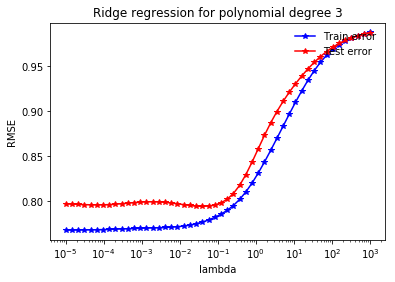

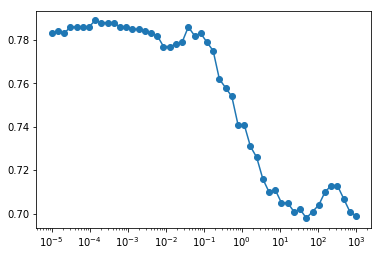

In [85]:
seed = 42
degree = 3
split_ratio = 0.8
ridge_regression_demo(x, y, degree, split_ratio, seed)

In [ ]:
print(id_out_test.shape)
x_out_test_std = standardize_features(x_out_test)
x_out = x_out_test_std[0]
tx_out = build_poly(x_out, 2)

create_csv_submission(id_out_test, predict_labels(w_rr, tx_out) , '../results/rr_pred.csv')
create_csv_submission(id_out_test, predict_labels(w_gd, tx_out) , '../results/gd_pred_accel.csv')
create_csv_submission(id_out_test, predict_labels(w_lsq, tx_out) , '../results/lsq_pred.csv')
#create_csv_submission(id_out_test, predict_labels(w_sgd, tx_out) , '../results/sgd_pred_noadapt.csv')

In [3]:



cross_validation_demo(x, y, ridge_regression, args_rr, k_fold=2, degree = 2)

Using method ridge_regression
Using lambda = 1.0e-07
Using lambda = 1.3e-06
Using lambda = 1.7e-05
Using lambda = 2.2e-04
Using lambda = 2.8e-03
Using lambda = 3.6e-02
Using lambda = 4.6e-01
Using lambda = 6.0e+00
Using lambda = 7.7e+01
Using lambda = 1.0e+03
Best lambda from error: 4.64e-01
Best lambda from accuracy: 1.29e-06


In [ ]:
def bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te):
    """visualize the bias variance decomposition."""
    rmse_tr_mean = np.expand_dims(np.mean(rmse_tr, axis=0), axis=0)
    rmse_te_mean = np.expand_dims(np.mean(rmse_te, axis=0), axis=0)
    print(rmse_te_mean, rmse_tr_mean)
    plt.plot(degrees,
             rmse_tr.T,
             'b',
             linestyle="-",
             color=([0.7, 0.7, 1]),
             label='train',
             linewidth=0.3)
    plt.plot(degrees,
             rmse_te.T,
             'r',
             linestyle="-",
             color=[1, 0.7, 0.7],
             label='test',
             linewidth=0.3)
    plt.plot(degrees,
             rmse_tr_mean.T,
             'b',
             linestyle="-",
             label='train',
             linewidth=3)
    plt.plot(degrees,
             rmse_te_mean.T,
             'r',
             linestyle="-",
             label='test',
             linewidth=3)
    plt.ylim(0.7, 1)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")
    plt.savefig("bias_variance")


def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    ratio_train = 0.5
    degrees = range(1, 8)
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        # split data with a specific seed
        x_train, y_train, x_test, y_test = split_data(x, y, ratio_train, seed)
        x_train_std = standardize(x_train)[0]
        x_test_std = standardize(x_test)[0]
        for index_degrees, degree in enumerate(degrees):
            tx_train = build_poly(x_train_std, degree)
            tx_test = build_poly(x_test_std, degree)
            weight, loss_tr = ridge_regression(y_train, tx_train, 1.89e-05 )
            loss_te = compute_loss(y_test, tx_test, weight, kind='mse')
            rmse_tr[index_seed, index_degrees] = np.sqrt(2 * loss_tr)
            rmse_te[index_seed, index_degrees] = np.sqrt(2 * loss_te)
    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)


bias_variance_demo()

# Logistic regression NEW

In [26]:
w_init = np.zeros(tx_train.shape[1])
max_iter = 1000
gamma = 1e-5
w_lrgd, loss_lrgd = logistic_regression(y_train,
                                        tx_train,
                                        w_init,
                                        max_iter,
                                        gamma,
                                        pr=False,
                                        adapt_gamma=False,
                                       accel=False,
                                       new=True)

lrgd_prediction = predict_labels(w_lrgd, tx_test)

acc_lrgd = accuracy_ratio(lrgd_prediction, y_test)

print('Accuracy ratio = %.3f' % acc_lrgd)
print('Test loss = %.3f' % compute_loss_logistic_new(y_test, tx_test, w_lrgd))
print('Train loss = %.3f' % loss_lrgd)
print((w_lrgd))

Accuracy ratio = 0.803
Test loss = 849.962
Train loss = 3368.144
[-0.11252881  0.56249914 -0.70734386  0.07221543  0.21124136  0.47648587
 -0.11628118  0.26375989 -0.35192631  0.16578181  0.59773594 -0.00686058
  0.03923464  0.3522235   0.07278065  0.08853583 -0.0550296  -0.06087281
 -0.06022777  0.01697526  0.11249201 -0.90652965  0.13185629 -0.8545514
  0.00394634 -0.31464538  0.03551931  0.02057922  0.04513402  0.40097713
 -0.0549146  -0.09740322  0.01470469  0.00540386 -0.26994535  0.03664979
  0.10355341 -0.03171698 -0.21074765 -0.11798162  0.02071415]


In [ ]:
lambda_ = 100
gamma = 5e-6
w_rlrgd, loss_rlrgd = reg_logistic_regression(y_train,
                                              tx_train,
                                              lambda_,
                                              w_init,
                                              max_iter,
                                              gamma,
                                              pr=True,
                                              adapt_gamma=False, 
                                              accel=False,
                                              new = True)
rlrgd_prediction = predict_labels(w_rlrgd, tx_test)
acc_rlrgd = accuracy_ratio(rlrgd_prediction, y_test)
print('Accuracy ratio = %.3f' % acc_rlrgd)
print('Test loss = %.3f' % compute_loss_logistic_new(y_test, tx_test, w_rlrgd))
print('Train loss = %.3f' % loss_rlrgd)
print((w_rlrgd))

# Bias-variance

2


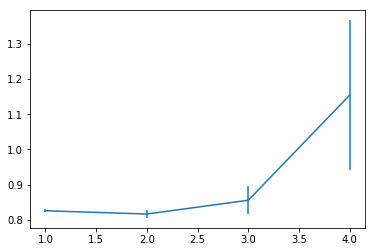

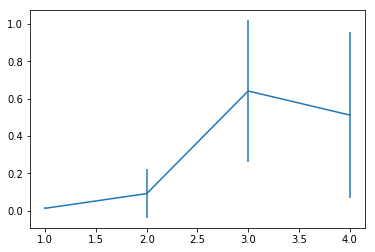

In [54]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""

    index = np.arange(k_indices.shape[0])
    index_te = k
    index_tr = index[index != index_te]

    x_tr = x[np.ravel(k_indices[index_tr])]
    x_te = x[k_indices[index_te]]
    y_tr = y[np.ravel(k_indices[index_tr])]
    y_te = y[k_indices[index_te]]
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)

    weight, loss_tr = ridge_regression(y_tr, tx_tr, lambda_)

    loss_te = compute_loss(y_te, tx_te, weight)
    accuracy = accuracy_ratio(predict_labels(weight, tx_test), y_test)
    return loss_tr, loss_te, accuracy, weight


def best_degree_lambda(y, x):
    """The entry."""
    # define parameters
    seeds = range(20)
    lambdas = np.logspace(-7, 0, 30)
    k_fold = 5
    ratio_train = 0.3
    degrees = range(1, 5)

    # define list to store the variable
    rmse_te = np.empty((len(seeds), len(degrees)))
    lambda_all = np.empty((len(seeds), len(degrees)))
    variance_te = np.empty(len(degrees))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)

        x_tr, y_tr, x_te, y_te = split_data(x, y, ratio_train, seed)
        y_tr, x_tr, _, _, _, _ = preprocess(x_train,
                                            y_train,
                                            clean=clean,
                                            dopca=dopca,
                                            max_comp=max_comp,
                                            remove_cols=remove_cols,
                                            cols=cols)
        y_te, x_te, _, _, _, _ = preprocess(x_test,
                                            y_test,
                                            clean=clean,
                                            dopca=dopca,
                                            max_comp=max_comp,
                                            remove_cols=remove_cols,
                                            cols=cols)
        k_indices = build_k_indices(y_tr, k_fold, seed)
        for index_deg, deg in enumerate(degrees):
            tx_te = build_poly(x_te, deg)
            ws_lambda = []
            loss_te_lambda = np.empty(len(lambdas))
            loss_tr_lambda = np.empty(len(lambdas))
            acc_lambda = np.empty(len(lambdas))
            for index_l, lambda_ in enumerate(lambdas):
                ws_k = []
                loss_te_k = np.empty(k_fold)
                loss_tr_k = np.empty(k_fold)
                acc_k = np.empty(k_fold)
                for k in range(k_fold):
                    loss_tr_tmp, loss_te_tmp, acc_tmp, w_tmp = cross_validation(
                        y_tr, x_tr, k_indices, k, lambda_, deg)
                    loss_te_k[k] = loss_te_tmp
                    loss_tr_k[k] = loss_tr_tmp
                    ws_k.append(w_tmp)
                loss_te_lambda[index_l] = np.mean(loss_te_k)
                loss_tr_lambda[index_l] = np.mean(loss_tr_k)
                ws_lambda.append(ws_k)

            ind_opt_lambda = np.argmin(loss_te_lambda)
            ws_opt = ws_lambda[ind_opt_lambda]

            loss_te = np.mean(
                [np.sqrt(2 * compute_loss(y_te, tx_te, w)) for w in ws_opt])
            rmse_te[index_seed, index_deg] = loss_te
            lambda_all[index_seed, index_deg] = lambdas[ind_opt_lambda]

    variance_te = np.std(rmse_te, axis=0)

    plt.figure(1)
    plt.errorbar(degrees, np.mean(rmse_te, axis=0), yerr=variance_te)
    plt.figure(2)
    plt.errorbar(degrees,
                 np.mean(lambda_all, axis=0),
                 yerr=np.std(lambda_all, axis=0))
    print(degrees[np.argmin(np.mean(rmse_te, axis=0))])
    return np.mean(rmse_te, axis=0), variance_te
    #plt.figure(2)
    #plt.boxplot(rmse_te)


rmse_CV, var_CV = best_degree_lambda(y, x)

In [55]:
rmse_CV

array([0.82530948, 0.81605139, 0.85528506, 1.15471421])